In [1]:
# !python /Users/kit/Documents/Phys_Working/LLM_SR/check_path.py

# import sys
# print("\nAdding project directory to Python path...")
# sys.path.insert(0, '/Users/kit/Documents/Phys_Working/LLM_SR')
# print(f"  - Added: {sys.path[0]}")

import llmlex
import openai

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:

api_key = os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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"
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

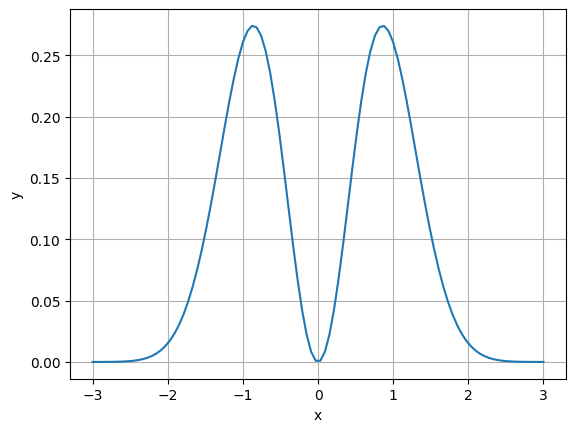

In [3]:
x = np.linspace(-3, 3, 100)
y = np.exp(-x**2)*np.sin(x)**2
#y = np.pi*np.ones(100)

plt.plot(x, y,label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend()
plt.savefig('plot.png')

# Getting the Base64 string
base64_image = llmlex.images.encode_image('plot.png')

In [4]:
r = llmlex.single_call(client, base64_image, x, y, model="openai/gpt-4o",function_list=None, system_prompt=None)
print(r)

2025-04-02 16:54:29,801 - llmlex.llmLEx - INFO - Extracted ansatz: params[0] * np.exp(-((x - params[1])**2) / params[... with 6 parameters
2025-04-02 16:54:30,154 - llmlex.llmLEx - INFO - Fit result: score=-0.07679153978824615, params=[ 0.27934648  0.9168568   0.31402815  0.27934709 -0.91685809  0.31402524]


{'params': array([ 0.27934648,  0.9168568 ,  0.31402815,  0.27934709, -0.91685809,
        0.31402524]), 'score': -0.07679153978824615, 'ansatz': 'params[0] * np.exp(-((x - params[1])**2) / params[2]) + params[3] * np.exp(-((x - params[4])**2) / params[5])', 'Num_params': 6, 'response': ChatCompletion(id='gen-1743627267-1qAqSTTOkpW9V6hZhEqv', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\ncurve_1 = lambda x, *params: params[0] * np.exp(-((x - params[1])**2) / params[2]) + params[3] * np.exp(-((x - params[4])**2) / params[5])\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), native_finish_reason='stop')], created=1743627267, model='openai/gpt-4o', object='chat.completion', service_tier=None, system_fingerprint='fp_de57b65c90', usage=CompletionUsage(completion_tokens=62, prompt_tokens=530, total_tokens=592, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=No

In [5]:
population_size = 25
num_of_generations = 10
start = llmlex.llm.check_key_limit(client)
res = llmlex.run_genetic(client, base64_image, x, y, population_size,num_of_generations, 
                        temperature=1., model="openai/gpt-4o", system_prompt=None, elite=True, use_async=True, exit_condition=1e-5)
print(f"Credits spent: {start - llmlex.llm.check_key_limit(client)}")

2025-04-02 16:54:39,006 - llmlex.llmLEx - INFO - Constant function is not a good fit: Score: -4.662089824676514, for constant: [0.09243326]
2025-04-02 16:54:39,006 - llmlex.llmLEx - INFO - Generating initial population asynchronously
2025-04-02 16:54:47,487 - llmlex.llmLEx - INFO - Generated 25 individuals
2025-04-02 16:54:47,488 - llmlex.llmLEx - INFO - Initial population best: score=-0.07679153978824615, params=[ 0.27934648  0.9168568   0.31402815  0.27934709 -0.91685809  0.31402524], ansatz: params[0] * np.exp(-((x - params[1]) ** 2) / params[2]) + params[3] * np.exp(-((x - params[4]) ** 2)...
2025-04-02 16:54:47,490 - llmlex.llmLEx - INFO - Generation 1/9: Generating 25 new individuals. Elitism? True
2025-04-02 16:54:52,799 - llmlex.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-04-02 16:54:54,016 - llmlex.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist wi


API Call Statistics:
  Successful calls (end-to-end): 49
  Failed calls: 3
  Success rate: 94.23%

Breakdown by processing stage:
  Api Call: 52 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 49 succeeded, 3 failed (94.23% success)
  Function Conversion: 49 succeeded, 0 failed (100.00% success)
  Curve Fitting: 49 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - llm refusal: 3

Fitting warnings:
  - covariance estimation: 2
  - other warnings: 114
Credits spent: 0.0


In [6]:
len(res[0])

25

In [7]:
highest_score_element = max((item for sublist in res for item in sublist), key=lambda item: item['score'])
print(highest_score_element['ansatz'])

params[0] * np.exp(-params[1]*x**2) * np.sin(params[2]*x)**2


In [8]:
print(highest_score_element['function_list'])

None


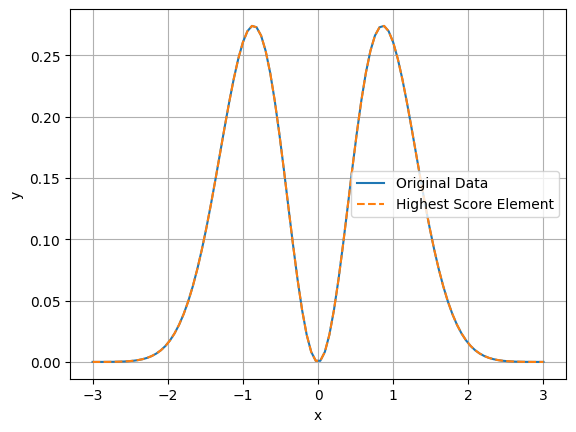

In [9]:
# Extract the parameters and the ansatz function from the highest_score_element
params = highest_score_element['params']
ansatz = highest_score_element['ansatz']

# Define the ansatz function
def ansatz_function(x, params):
    return eval(ansatz)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the highest score element
plt.plot(x, ansatz_function(x, params), label='Highest Score Element', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

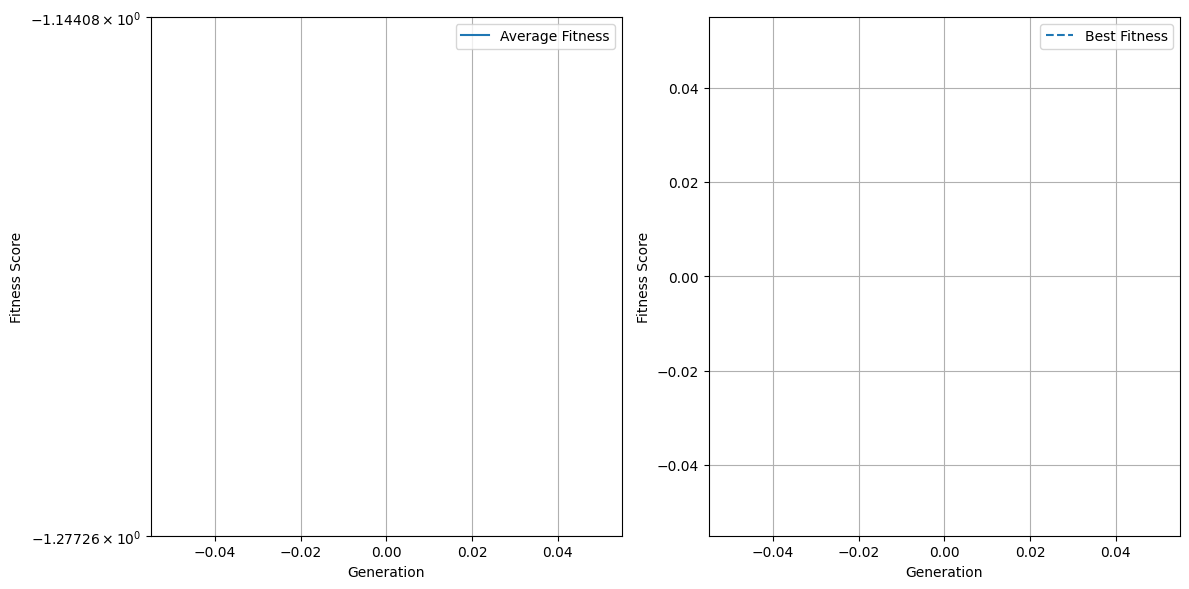

In [10]:
# Remove infinite scores
filtered_res = [[ind for ind in generation if np.isfinite(ind['score'])] for generation in res]

# Extract fitness scores from the filtered results
average_fitness = [np.mean([ind['score'] for ind in generation]) for generation in filtered_res]
best_fitness = [max([ind['score'] for ind in generation]) for generation in filtered_res]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the average fitness
axs[0].plot(range(len(average_fitness)), average_fitness, label='Average Fitness')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Fitness Score')
axs[0].set_yscale('symlog')
axs[0].legend()
axs[0].grid(True)

# Plot the best fitness
axs[1].plot(range(len(average_fitness)), best_fitness, label='Best Fitness', linestyle='--')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Fitness Score')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()